# Part 4: Quantization

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

os.environ['PATH'] = '/tools/Xilinx/Vitis/2022.1/bin:' + os.environ['PATH']
import numpy as np

2023-07-18 08:09:38.604417: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 08:09:38.714024: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [4]:
x_train.shape

(60000, 28, 28)

In [6]:
from skimage.transform import resize
new_size = (14,14)
X_train_resized = np.array([resize(image,new_size) for image in x_train])
X_test_resized = np.array([resize(image,new_size) for image in x_test])

In [8]:
X_train_resized.shape

(60000, 14, 14)

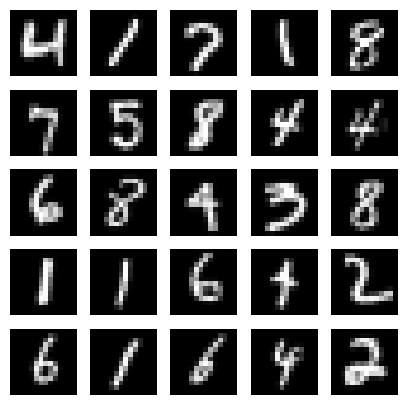

In [9]:
# sample 25 mnist digits from train dataset
indexes = np.random.randint(0, x_train.shape[0], size=25)
images = X_train_resized[indexes]
labels = y_train[indexes]


# plot the 25 mnist digits
plt.figure(figsize=(5,5))
for i in range(len(indexes)):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
plt.show()
plt.savefig("mnist-samples.png")
plt.close('all')

In [10]:
# image dimensions (assumed square)
image_size = X_train_resized.shape[1]
input_size = image_size * image_size
input_size

196

In [20]:
X_train = np.reshape(X_train_resized, [-1, input_size])
X_test = np.reshape(X_test_resized, [-1, input_size])

In [16]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [22]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
X_train

array([[-0.00409751, -0.00911442, -0.01238149, ..., -0.0314962 ,
        -0.02067988, -0.00593342],
       [-0.00409751, -0.00911442, -0.01238149, ..., -0.0314962 ,
        -0.02067988, -0.00593342],
       [-0.00409751, -0.00911442, -0.01238149, ..., -0.0314962 ,
        -0.02067988, -0.00593342],
       ...,
       [-0.00409751, -0.00911442, -0.01238149, ..., -0.0314962 ,
        -0.02067988, -0.00593342],
       [-0.00409751, -0.00911442, -0.01238149, ..., -0.0314962 ,
        -0.02067988, -0.00593342],
       [-0.00409751, -0.00911442, -0.01238149, ..., -0.0314962 ,
        -0.02067988, -0.00593342]])

In [24]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [25]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks
from tensorflow.keras.layers import Activation
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu

We're using `QDense` layer instead of `Dense`, and `QActivation` instead of `Activation`. We're also specifying `kernel_quantizer = quantized_bits(6,0,0)`. This will use 6-bits (of which 0 are integer) for the weights. We also use the same quantization for the biases, and `quantized_relu(6)` for 6-bit ReLU activations.

In [154]:
# layer_1=196
# layer_2=56
# layer_3=64
# layer_4=32
# layer_5=10
# int_bits=1
# sign_bit=1
# bits=8
# model = Sequential()
# model.add(QDense(layer_2, input_shape=(layer_1,), name='fc1', kernel_quantizer=quantized_bits(bits,int_bits,alpha=1,use_stochastic_rounding=True),bias_quantizer=quantized_bits(bits,int_bits,alpha=1),
#                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)   ))
# model.add(QActivation(activation=quantized_relu(bits,int_bits,use_stochastic_rounding=False), name='relu1'))
# model.add(QDense(layer_3, name='fc2',
#                 kernel_quantizer=quantized_bits(bits,int_bits,alpha=1,use_stochastic_rounding=True), bias_quantizer=quantized_bits(bits,int_bits,alpha=1),
#                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001 ) ))
# model.add(QActivation(activation=quantized_relu(bits,int_bits,use_stochastic_rounding=False), name='relu2'))
# model.add(QDense(layer_4, name='fc3',
#                 kernel_quantizer=quantized_bits(bits,int_bits,alpha=1,use_stochastic_rounding=True), bias_quantizer=quantized_bits(bits,int_bits,alpha=1),
#                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001 ) ))
# model.add(QActivation(activation=quantized_relu(bits,int_bits,use_stochastic_rounding=False), name='relu3'))
# model.add(QDense(layer_5, name='output',
#                 kernel_quantizer=quantized_bits(bits,int_bits,alpha=1,use_stochastic_rounding=True), bias_quantizer=quantized_bits(bits,int_bits,alpha=1),
#                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001 ) ))
# model.add(Activation(activation='softmax', name='softmax'))

In [157]:
# from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
# from tensorflow_model_optimization.sparsity.keras import strip_pruning
# from qkeras.utils import model_save_quantized_weights

# pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0, begin_step=2000, frequency=100)}
# model = prune.prune_low_magnitude(model, **pruning_params)

# adam = Adam(lr=0.003)

# model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
# callbacks= all_callbacks( outputDir = 'jt_classification')
# callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
# model.fit(X_train, y_train, batch_size=1024,
#           epochs=25,validation_split=0.25, verbose=1, shuffle=True,
#           callbacks = callbacks.callbacks);
# model = strip_pruning(model)
# model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
# model_save_quantized_weights(model, "test_weights")
# model.save("MNIST")

Epoch 1/25
43/44 [============================>.] - ETA: 0s - loss: 0.1587 - accuracy: 0.9866
***callbacks***
saving losses to jt_classification/losses.log

Epoch 1: val_loss improved from inf to 0.21456, saving model to jt_classification/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 0.21456, saving model to jt_classification/KERAS_check_best_model_weights.h5

Epoch 1: saving model to jt_classification/KERAS_check_model_last.h5

Epoch 1: saving model to jt_classification/KERAS_check_model_last_weights.h5

***callbacks end***

44/44 [==============================] - 4s 34ms/step - loss: 0.1585 - accuracy: 0.9866 - val_loss: 0.2146 - val_accuracy: 0.9673 - lr: 0.0010
Epoch 2/25
43/44 [============================>.] - ETA: 0s - loss: 0.1534 - accuracy: 0.9875
***callbacks***
saving losses to jt_classification/losses.log

Epoch 2: val_loss improved from 0.21456 to 0.21440, saving model to jt_classification/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 0.2


***callbacks end***

44/44 [==============================] - 1s 21ms/step - loss: 0.1371 - accuracy: 0.9926 - val_loss: 0.2080 - val_accuracy: 0.9680 - lr: 1.2500e-04
Epoch 13/25
44/44 [==============================] - ETA: 0s - loss: 0.1370 - accuracy: 0.9924
***callbacks***
saving losses to jt_classification/losses.log

Epoch 13: val_loss improved from 0.20802 to 0.20774, saving model to jt_classification/KERAS_check_best_model.h5

Epoch 13: val_loss improved from 0.20802 to 0.20774, saving model to jt_classification/KERAS_check_best_model_weights.h5

Epoch 13: saving model to jt_classification/KERAS_check_model_last.h5

Epoch 13: saving model to jt_classification/KERAS_check_model_last_weights.h5

***callbacks end***

44/44 [==============================] - 1s 20ms/step - loss: 0.1370 - accuracy: 0.9924 - val_loss: 0.2077 - val_accuracy: 0.9689 - lr: 1.2500e-04
Epoch 14/25
43/44 [============================>.] - ETA: 0s - loss: 0.1367 - accuracy: 0.9924
***callbacks***
saving l

Epoch 25/25
42/44 [===========================>..] - ETA: 0s - loss: 0.1348 - accuracy: 0.9930
***callbacks***
saving losses to jt_classification/losses.log

Epoch 25: val_loss improved from 0.20648 to 0.20635, saving model to jt_classification/KERAS_check_best_model.h5

Epoch 25: val_loss improved from 0.20648 to 0.20635, saving model to jt_classification/KERAS_check_best_model_weights.h5

Epoch 25: saving model to jt_classification/KERAS_check_model_last.h5

Epoch 25: saving model to jt_classification/KERAS_check_model_last_weights.h5

***callbacks end***

44/44 [==============================] - 1s 21ms/step - loss: 0.1343 - accuracy: 0.9932 - val_loss: 0.2063 - val_accuracy: 0.9691 - lr: 1.5625e-05
... quantizing model


INFO:tensorflow:Assets written to: MNIST/assets


INFO:tensorflow:Assets written to: MNIST/assets


In [159]:
model = tf.keras.models.load_model("MNIST")

In [160]:
accuracy=model.evaluate(X_test,y_test)
print(" ACCURACY IS "+str(accuracy[1]) )

313/313 [==============================] - 2s 3ms/step - loss: 0.1901 - accuracy: 0.9739
 ACCURACY IS 0.9739000201225281


In [161]:
model.get_weights()

[array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [ 0.      , -0.015625,  0.      , ...,  0.      ,  0.03125 ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         -0.015625]], dtype=float32),
 array([ 0.      , -0.0625  , -0.0625  ,  0.109375,  0.03125 ,  0.015625,
         0.15625 ,  0.046875, -0.03125 , -0.046875, -0.09375 ,  0.109375,
        -0.078125, -0.109375,  0.25    ,  0.109375,  0.      ,  0.125   ,
         0.      , -0.03125 ,  0.109375,  0.015625,  0.015625, -0.171875,
        -0.03125 , -0.015625, -0.09375 ,  0.      , -0.15625 ,  0.21875 ,
        -0.015625,  0.0625  ,  0.171875,  0.09375 ,  0.     

In [96]:
import estimate as es

In [178]:
from importlib import reload
reload(es)

<module 'estimate' from '/home/edge/Desktop/argykokk/hls4ml-tutorial/networks/MNIST/estimate.py'>

In [176]:
param=2
reuse=100

In [179]:
%%time
#input_num, neurons_num, layer_id, model
ffs = es.estimate(192,56,0,model,reuse,param)
luts, ffs = es.estimate(56,64,2,model,reuse,param)
luts, ffs = es.estimate(64,32,4,model,reuse,param)
luts, ffs = es.estimate(32,10,6,model,reuse,param)

zero weight are:  5100
non-zero weight are:  5652
Mul ins = 120 and Max muls = 57 and Saved muls = 63 Reuse factor = 100
DSPs: 57
LUT cost2= 22121 bias acc= 784 mult acc78344
LUTs prediction: 101249
Initial muls: 10752 Real muls: 5652 Initial neurons: 56 Tuned neurons: 30
FFs prediction: 107859
zero weight are:  936
non-zero weight are:  2648
Mul ins = 219 and Max muls = 27 and Saved muls = 192 Reuse factor = 100
DSPs: 27
LUT cost2= 13875 bias acc= 896 mult acc36176
LUTs prediction: 50947
Initial muls: 3584 Real muls: 2648 Initial neurons: 64 Tuned neurons: 48
FFs prediction: 49563
zero weight are:  576
non-zero weight are:  1472
Mul ins = 188 and Max muls = 15 and Saved muls = 173 Reuse factor = 100
DSPs: 15
LUT cost2= 10863 bias acc= 448 mult acc20160
LUTs prediction: 31471
Initial muls: 2048 Real muls: 1472 Initial neurons: 32 Tuned neurons: 23
FFs prediction: 28355
zero weight are:  27
non-zero weight are:  293
Mul ins = 120 and Max muls = 3 and Saved muls = 117 Reuse factor = 100


/home/edge/miniconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearRegression from version 1.1.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/edge/miniconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearRegression from version 1.1.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/edge/miniconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearRegression from version 1.1.2 when 

In [162]:
import hls4ml
import plotting

config = hls4ml.utils.config_from_keras_model(model, granularity='name')
config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='mnist/hls4ml_prj', part='xc7z007s-clg225-2'
)
hls_model.compile()

y_qkeras = model.predict(np.ascontiguousarray(X_test))
y_hls = hls_model.predict(np.ascontiguousarray(X_test))

None
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 196]], output shape: [None, 196]
Layer name: fc1, layer type: QDense, input shapes: [[None, 196]], output shape: [None, 56]
Layer name: relu1, layer type: Activation, input shapes: [[None, 56]], output shape: [None, 56]
Layer name: fc2, layer type: QDense, input shapes: [[None, 56]], output shape: [None, 64]
Layer name: relu2, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc3, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 10]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 10]], output shape: [None, 10]
-----------------------------------
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Strategy:   